<a href="https://colab.research.google.com/github/sreeramreddy68/Machine-Learning/blob/main/mod3_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from collections import Counter

In [ ]:
def predict(X_train, y_train, X_test, k):
    distances = []
    targets = []

    for i in range(len(X_train)):
        # compute and store L2 distance
        distances.append([np.sqrt(np.sum(np.square(X_test - X_train[i, :]))), i])

    distances = sorted(distances)

    for i in range(k):
        index = distances[i][1]
        targets.append(y_train[index])

    # return most common target
    return Counter(targets).most_common(1)[0][0]

In [ ]:
def k_nearest_neighbor(X_train, y_train, X_test, k):

    assert k <= len(X_train), "[!] K cannot be larger than number of samples."

    # loop over all observations
    predictions = []
    for i in range(len(X_test)):
        predictions.append(predict(X_train, y_train, X_test[i, :], k))

    return np.asarray(predictions)

In [ ]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

In [ ]:
def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

In [ ]:
from sklearn.datasets import load_iris

data = load_iris()

df = pd.DataFrame(data=data.data, columns=data.feature_names)

df["target"] = data.target

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
X = np.array(df[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']])
y = np.array(df['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=17)

In [ ]:
# Making our predictions
predictions = k_nearest_neighbor(X_train, y_train, X_test, 7)

# evaluating accuracy
accuracy = Accuracy(y_test, predictions)
print("The accuracy of our classifier is {} %".format(100*accuracy))

The accuracy of our classifier is 94.0 %


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

sklearn_knn = KNeighborsClassifier(n_neighbors=7)
sklearn_knn.fit(X_train,y_train)
sklearn_predictions = sklearn_knn.predict(X_test)
accuracy = accuracy_score(y_test, sklearn_predictions)
print("The accuracy of Sklearn classifier is {} %".format(100*accuracy))

The accuracy of Sklearn classifier is 94.0 %


In [ ]:
import numpy as np
from collections import Counter

def k_nearest_neighbor(X_train, y_train, X_test, k):
    neighbors_info = []

    for test_point in X_test:
        # Calculate Euclidean distances from test_point to all training data
        distances = np.sqrt(np.sum((X_train - test_point) ** 2, axis=1))

        # Combine the distances with the corresponding labels
        distance_label_pairs = list(zip(y_train, distances))

        # Sort by distance
        sorted_neighbors = sorted(distance_label_pairs, key=lambda x: x[1])

        # Take top k
        k_nearest = sorted_neighbors[:k]

        # Append to output list
        neighbors_info.append(k_nearest)

    return neighbors_info
neighbors = k_nearest_neighbor(X_train, y_train, X_test, 7)
print("K-nearest neighbors with distances for the first test sample:")
print(neighbors[0])  # Output: list of (label, distance) for first test sample


K-nearest neighbors with distances for the first test sample:
[(np.int64(0), np.float64(0.3464101615137753)), (np.int64(0), np.float64(0.3872983346207418)), (np.int64(0), np.float64(0.41231056256176646)), (np.int64(0), np.float64(0.4582575694955838)), (np.int64(0), np.float64(0.45825756949558394)), (np.int64(0), np.float64(0.46904157598234253)), (np.int64(0), np.float64(0.47958315233127247))]


In [ ]:
#@title Plotting Voronoi regions
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

def voronoi_finite_polygons_2d(vor, radius=None):


    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

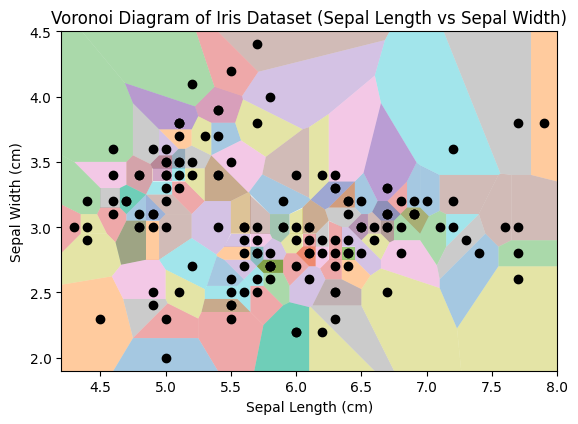

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

# Load data
from sklearn.datasets import load_iris
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)

# Use sepal length and width
points = df[['sepal length (cm)', 'sepal width (cm)']].to_numpy()

# Compute Voronoi tesselation
vor = Voronoi(points)

# Helper function to make infinite regions finite
def voronoi_finite_polygons_2d(vor, radius=100):
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    all_ridges = {}

    # Collect all ridges
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct finite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t = t / np.linalg.norm(t)
            n = np.array([-t[1], t[0]])

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        vs = np.array([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = [v for _, v in sorted(zip(angles, new_region))]

        new_regions.append(new_region)

    return new_regions, np.array(new_vertices)

# Get finite polygons
regions, vertices = voronoi_finite_polygons_2d(vor)

# Plotting
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:, 0], points[:, 1], 'ko')
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Sepal Width (cm)")
plt.title("Voronoi Diagram of Iris Dataset (Sepal Length vs Sepal Width)")
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)
plt.gca().set_aspect('equal')
plt.show()


In [ ]:
from matplotlib.colors import ListedColormap
import seaborn as sns


def decision_boundary_plot(x_dec,y_dec,k):
  h = .02  # step size in the mesh

  # Create color maps
  n = len(set(y_dec))
  cmap_light = ListedColormap(['pink', 'green', 'cyan','yellow'][:n])
  cmap_bold = ['pink', 'darkgreen', 'blue','yellow'][:n]

  for weights in ['uniform', 'distance']:
      # we create an instance of Neighbours Classifier and fit the data.
      clf = KNeighborsClassifier(n_neighbors=k, weights=weights)
      clf.fit(x_dec, y_dec)

      # Plot the decision boundary. For that, we will assign a color to each
      # point in the mesh [x_min, x_max]x[y_min, y_max].
      x_min, x_max = x_dec[:, 0].min() - 1, x_dec[:, 0].max() + 1
      y_min, y_max = x_dec[:, 1].min() - 1, x_dec[:, 1].max() + 1
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                          np.arange(y_min, y_max, h))
      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

      # Put the result into a color plot
      Z = Z.reshape(xx.shape)
      plt.figure(figsize=(8, 6))
      plt.contourf(xx, yy, Z, cmap=cmap_light)

      # Plot also the training points
      sns.scatterplot(x=x_dec[:, 0], y=x_dec[:, 1], hue=y_dec,
                      palette=cmap_bold, alpha=1.0, edgecolor="black")
      plt.xlim(xx.min(), xx.max())
      plt.ylim(yy.min(), yy.max())
      plt.title("Multi-Classification (k = %i, weights = '%s')"% (k, weights))

  plt.show()


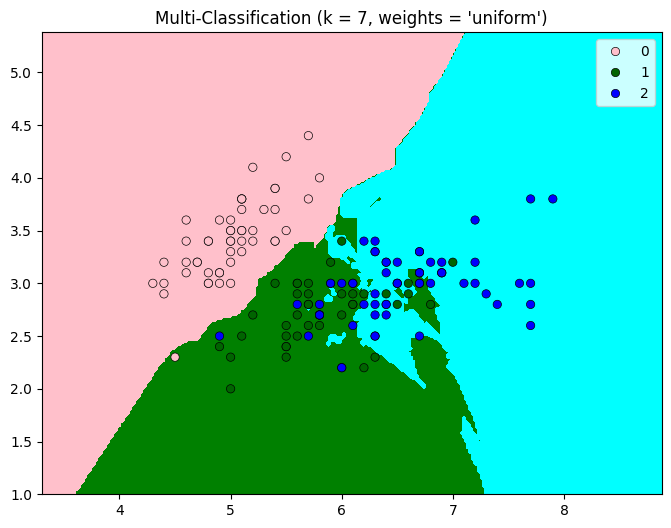

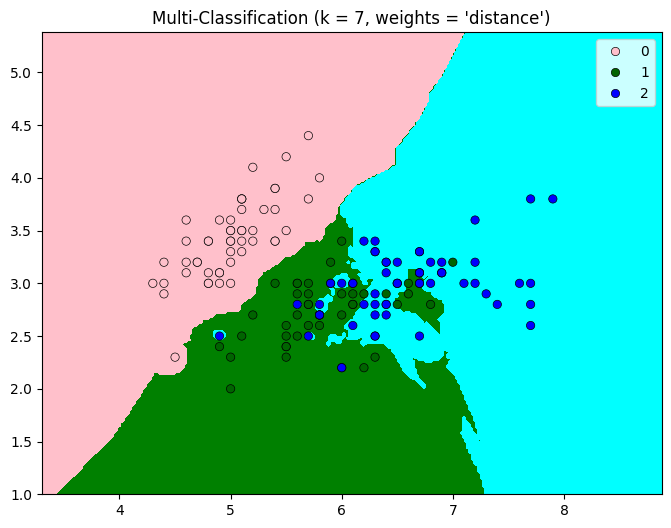

In [ ]:
x_pts = X[:,:2]
y_pts = y
decision_boundary_plot(x_pts,y_pts,7)

In [ ]:
from sklearn.decomposition import PCA

# PCA transformation to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  # X was defined earlier as the 4D features from Iris


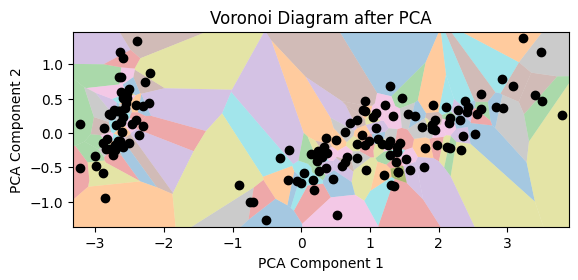

In [ ]:
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt

# Convert to 2D points
points_pca = X_pca
vor_pca = Voronoi(points_pca)

regions, vertices = voronoi_finite_polygons_2d(vor_pca)

# Plot Voronoi regions
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points_pca[:, 0], points_pca[:, 1], 'ko')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Voronoi Diagram after PCA")
plt.xlim(vor_pca.min_bound[0] - 0.1, vor_pca.max_bound[0] + 0.1)
plt.ylim(vor_pca.min_bound[1] - 0.1, vor_pca.max_bound[1] + 0.1)
plt.gca().set_aspect('equal')
plt.show()


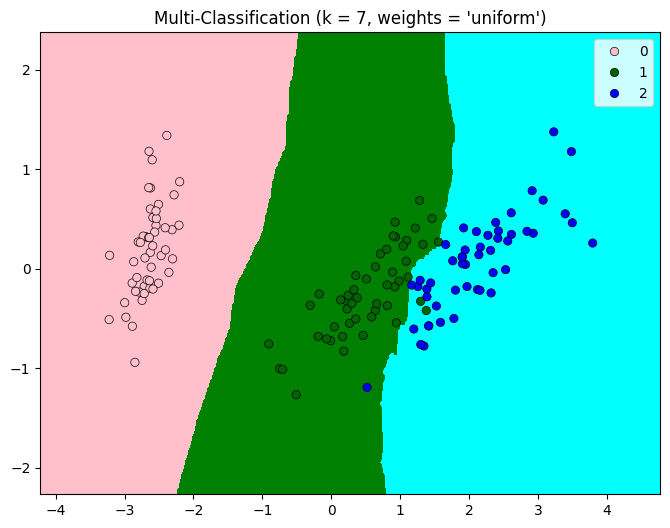

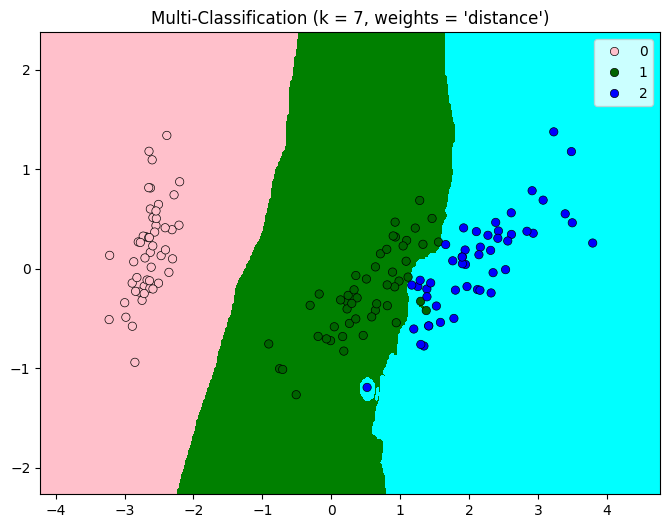

In [ ]:
# Use the same decision boundary plot function you defined
decision_boundary_plot(X_pca, y, k=7)


In [ ]:
# Upload the Car evaluation data CSV file that has been shared with you.
# Run this cell, click on the 'Choose files' button and upload the file.
from google.colab import files
uploaded = files.upload()

Saving car_evaluation.csv to car_evaluation.csv


In [ ]:
car_df = pd.read_csv('car_evaluation.csv')
car_df

,buying price,maintenance cost,num_doors,num_persons,lug_boot,safety,decision
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc
...,...,...,...,...,...,...,...
1722,low,low,5more,more,med,med,good
1723,low,low,5more,more,med,high,vgood
1724,low,low,5more,more,big,low,unacc
1725,low,low,5more,more,big,med,good


In [ ]:
for x in car_df.columns:
  # print(x)
  le = preprocessing.LabelEncoder()
  le.fit(car_df[x])
  car_df[x]=le.transform(car_df[x])

car_df

,buying price,maintenance cost,num_doors,num_persons,lug_boot,safety,decision
0,3,3,0,0,2,2,2
1,3,3,0,0,2,0,2
2,3,3,0,0,1,1,2
3,3,3,0,0,1,2,2
4,3,3,0,0,1,0,2
...,...,...,...,...,...,...,...
1722,1,1,3,2,1,2,1
1723,1,1,3,2,1,0,3
1724,1,1,3,2,0,1,2
1725,1,1,3,2,0,2,1


In [ ]:
dataset = car_df.values
X = dataset[:,0:6]
y = np.array(dataset[:,6])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
score = accuracy_score(y_test, predictions)
print("The accuracy of the classifier on Car evaluation dataset is {:.2f} %".format(100*score))

The accuracy of the classifier on Car evaluation dataset is 89.88 %


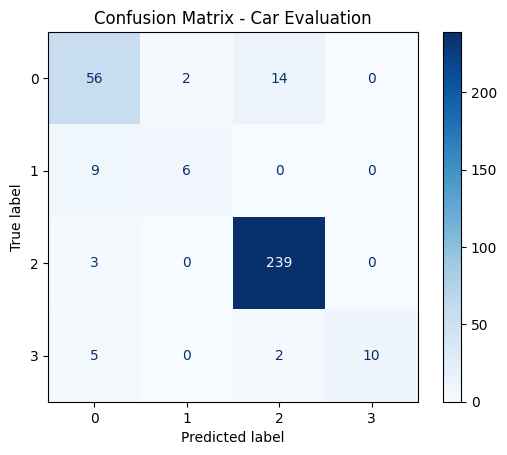

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Car Evaluation")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predictions)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.78      0.77        72
           1       0.75      0.40      0.52        15
           2       0.94      0.99      0.96       242
           3       1.00      0.59      0.74        17

    accuracy                           0.90       346
   macro avg       0.86      0.69      0.75       346
weighted avg       0.90      0.90      0.89       346



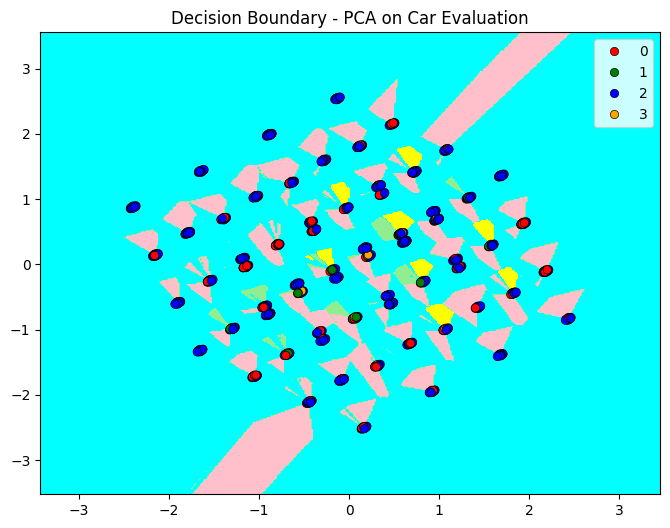

In [ ]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import seaborn as sns

# Reduce features to 2D for plotting
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Re-train on PCA data
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_train_pca, y_train)

# Plot decision boundary
def decision_boundary_plot_custom(x_dec, y_dec, k, title="Decision Boundary"):
    h = .02
    n = len(set(y_dec))
    cmap_light = ListedColormap(['pink', 'lightgreen', 'cyan', 'yellow'][:n])
    cmap_bold = ['red', 'green', 'blue', 'orange'][:n]

    x_min, x_max = x_dec[:, 0].min() - 1, x_dec[:, 0].max() + 1
    y_min, y_max = x_dec[:, 1].min() - 1, x_dec[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(x_dec, y_dec)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    sns.scatterplot(x=x_dec[:, 0], y=x_dec[:, 1], hue=y_dec,
                    palette=cmap_bold, edgecolor="black", alpha=1.0)
    plt.title(title)
    plt.show()

# Call plot
decision_boundary_plot_custom(X_train_pca, y_train, 5, "Decision Boundary - PCA on Car Evaluation")


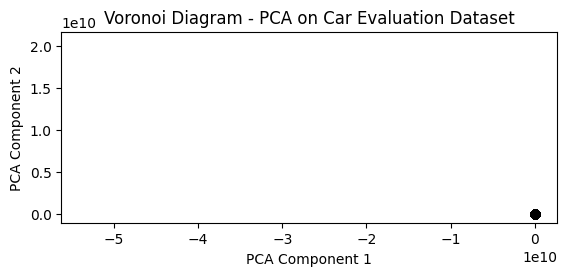

In [ ]:
from scipy.spatial import Voronoi

# Voronoi helper function reused from before
def voronoi_finite_polygons_2d(vor, radius=100):
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    all_ridges = {}

    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue
            t = vor.points[p2] - vor.points[p1]
            t = t / np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        vs = np.array([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = [v for _, v in sorted(zip(angles, new_region))]
        new_regions.append(new_region)

    return new_regions, np.array(new_vertices)

# Compute Voronoi
points = X_train_pca
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

# Plot Voronoi
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:, 0], points[:, 1], 'ko')
plt.title("Voronoi Diagram - PCA on Car Evaluation Dataset")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.gca().set_aspect('equal')
plt.show()
